In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Working with Tables
We are predicting the survival of the passengers in this notebook by building NN from scratch.

In [2]:
import os
from pathlib import Path

isKaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '') 
if isKaggle: path = Path('/kaggle/input/titanic')
else:
    path = Path.cwd()/'titanic'
    if not path.exists():
        import zipfile, kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [3]:
import numpy as np, pandas as pd, torch
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode = False, edgeitems=7)
pd.set_option('display.width', 140)

# Cleaning the data

In [4]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
df.fillna(modes, inplace = True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,B96 B98,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,B96 B98,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [8]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [9]:
df.describe(include = np.number)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Handling uneven Fare distribution

<Axes: >

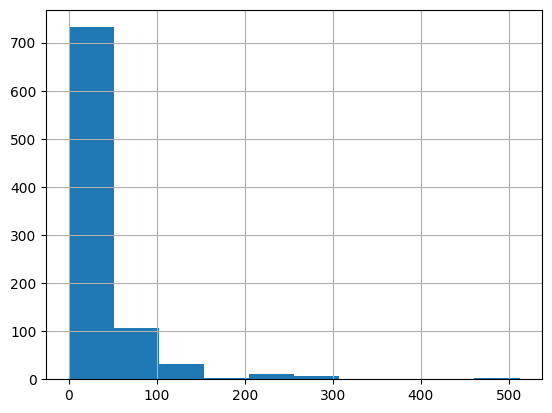

In [10]:
df.Fare.hist()

<Axes: >

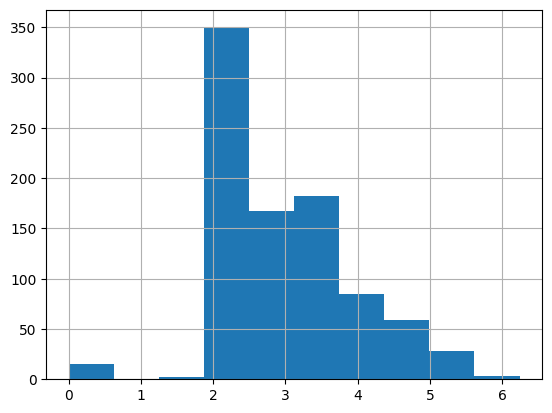

In [11]:
df['LogFare'] = np.log(df['Fare']+1)
df['LogFare'].hist()

In [12]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [13]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


Handling the category column data and converting it to dummy ariables

In [14]:
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'], dtype =float)

In [15]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [16]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [17]:
# Getting labels
from torch import tensor
t_dep = tensor(df.Survived)
t_dep[:10]

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

In [18]:
# Getting Independent Variables
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype = torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [19]:
t_indep.shape, len(t_indep.shape)

(torch.Size([891, 12]), 2)

# Setting up a linear Model


In [20]:
torch.manual_seed(42)
# Creating random parameter (coefficient) for each of the columns ie, 12

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) -  0.5
coeffs

tensor([ 0.3823,  0.4150, -0.1171,  0.4593, -0.1096,  0.1009, -0.2434,  0.2936,  0.4408, -0.3668,  0.4346,  0.0936])

In [21]:
# Matrix multiplied with a vector
# Element wise multiplication
t_indep * coeffs

tensor([[ 8.4099,  0.4150, -0.0000,  0.9692, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [14.5262,  0.4150, -0.0000,  1.9661, -0.0000,  0.1009, -0.2434,  0.0000,  0.0000, -0.3668,  0.0000,  0.0000],
        [ 9.9390,  0.0000, -0.0000,  1.0054, -0.0000,  0.1009, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [13.3794,  0.4150, -0.0000,  1.8330, -0.0000,  0.1009, -0.2434,  0.0000,  0.0000, -0.0000,  0.0000,  0.0936],
        [13.3794,  0.0000, -0.0000,  1.0117, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [ 9.1745,  0.0000, -0.0000,  1.0320, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.4346,  0.0000],
        [20.6425,  0.0000, -0.0000,  1.8224, -0.1096,  0.0000, -0.2434,  0.0000,  0.0000, -0.0000,  0.0000,  0.0936],
        ...,
        [ 9.5567,  0.0000, -0.0000,  0.9580, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [14.9085,  0.0000, -0.5857,  1.5641

In [22]:
# Getting the maximum values in each columns
vals, indices = t_indep.max(dim=0)
vals, indices

(tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000]),
 tensor([630, 159, 678, 258,   0,   1,   1,   9,   0,   1,   5,   0]))

In [23]:
# All number are in range (0-1)
t_indep = t_indep/vals
t_indep

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

In [24]:
preds = (t_indep * coeffs).sum(axis=1)

In [25]:
preds[:10]

tensor([0.7371, 0.0391, 0.9206, 0.4639, 0.7542, 1.0459, 0.2906, 0.7982, 0.9089, 0.3994])

Calculating Loss

In [26]:
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.6056)

In [27]:
def calc_preds(coeffs, indeps): return (indeps * coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Doing a gradient descent step

In [28]:
coeffs.requires_grad_()

tensor([ 0.3823,  0.4150, -0.1171,  0.4593, -0.1096,  0.1009, -0.2434,  0.2936,  0.4408, -0.3668,  0.4346,  0.0936], requires_grad=True)

In [29]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.6056, grad_fn=<MeanBackward0>)

In [30]:
loss.backward()

In [31]:
coeffs.grad

tensor([ 0.0883,  0.0272,  0.0056,  0.0608,  0.3423, -0.0853, -0.1324,  0.0202,  0.3692, -0.0786,  0.0842,  0.2514])

Moving towards lower loss by moving opposite of the gradients

In [32]:
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5696)


# Training the linear model

In [33]:
from fastai.data.transforms import RandomSplitter
trn_split, val_split = RandomSplitter(seed=42)(df)

In [34]:
trn_split, val_split

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

In [35]:
trn_indep, val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]

In [36]:
trn_indep.shape, trn_dep.shape

(torch.Size([713, 12]), torch.Size([713]))

In [37]:
val_indep.shape, val_dep.shape

(torch.Size([178, 12]), torch.Size([178]))

In [38]:
def update_coeffs(coeffs, lr): coeffs.sub_(coeffs.grad * lr)

In [39]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f'Epoch Loss: {loss:.3f}', end = ';\n')

In [40]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [41]:
# Training a model for few epochs
def train_model(epochs=30, lr=0.1 ):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr)
    return coeffs

In [42]:
coeffs = train_model(18, lr=0.02)

Epoch Loss: 0.536;
Epoch Loss: 0.532;
Epoch Loss: 0.525;
Epoch Loss: 0.515;
Epoch Loss: 0.503;
Epoch Loss: 0.489;
Epoch Loss: 0.477;
Epoch Loss: 0.466;
Epoch Loss: 0.449;
Epoch Loss: 0.424;
Epoch Loss: 0.396;
Epoch Loss: 0.373;
Epoch Loss: 0.354;
Epoch Loss: 0.338;
Epoch Loss: 0.321;
Epoch Loss: 0.306;
Epoch Loss: 0.297;
Epoch Loss: 0.295;


In [43]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2335),
 'SibSp': tensor(0.1025),
 'Parch': tensor(0.2530),
 'LogFare': tensor(0.1073),
 'Sex_male': tensor(-0.4166),
 'Sex_female': tensor(0.3314),
 'Pclass_1': tensor(0.8639),
 'Pclass_2': tensor(0.4225),
 'Pclass_3': tensor(0.2875),
 'Embarked_C': tensor(0.1840),
 'Embarked_Q': tensor(0.3267),
 'Embarked_S': tensor(0.1158)}

## Measuring Accuracy

In [44]:
preds = calc_preds(coeffs, val_indep)

In [45]:
results = val_dep.bool() == (preds>0.5)
results[:10]

tensor([True, True, True, True, True, True, True, True, True, True])

In [46]:
results.float().mean()

tensor(0.7921)

In [47]:
def acc(coeffs): return (val_dep.bool() == (calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7921)

# Using Sigmoid

In [48]:
preds[:20]

tensor([ 1.0550,  0.1648,  0.0210,  0.1432,  0.0940,  0.0883,  0.8792,  0.8332,  0.1986,  0.8419, -0.0691,  0.0877,  0.0729,  0.9130,
        -0.0780,  0.4887,  0.4303,  0.8954,  0.0644,  0.6831])

squishing prediction in the range of 0 to 1

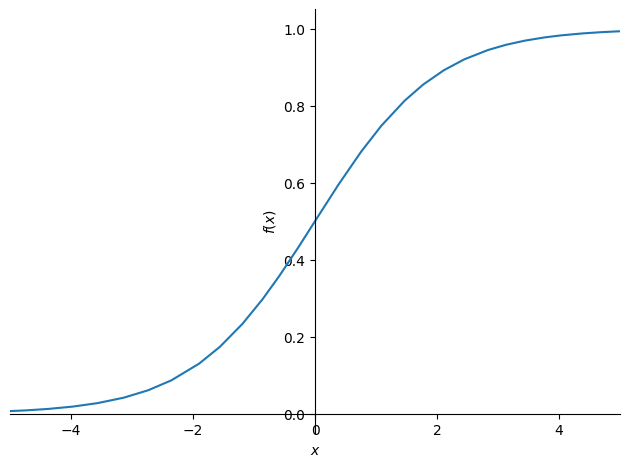

In [49]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

In [50]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps * coeffs).sum(axis=1))

In [51]:
coeffs = train_model(lr = 2)

Epoch Loss: 0.510;
Epoch Loss: 0.468;
Epoch Loss: 0.397;
Epoch Loss: 0.340;
Epoch Loss: 0.309;
Epoch Loss: 0.289;
Epoch Loss: 0.268;
Epoch Loss: 0.247;
Epoch Loss: 0.230;
Epoch Loss: 0.218;
Epoch Loss: 0.210;
Epoch Loss: 0.207;
Epoch Loss: 0.205;
Epoch Loss: 0.204;
Epoch Loss: 0.204;
Epoch Loss: 0.204;
Epoch Loss: 0.204;
Epoch Loss: 0.205;
Epoch Loss: 0.205;
Epoch Loss: 0.205;
Epoch Loss: 0.205;
Epoch Loss: 0.205;
Epoch Loss: 0.205;
Epoch Loss: 0.204;
Epoch Loss: 0.203;
Epoch Loss: 0.202;
Epoch Loss: 0.201;
Epoch Loss: 0.200;
Epoch Loss: 0.198;
Epoch Loss: 0.197;


In [52]:
coeffs

tensor([ -1.6562,  -1.1978,  -0.0264,   2.0475, -18.9596,  16.6258,   7.8170,   4.0900, -12.5817,   3.1918,   1.0449,  -5.8589],
       requires_grad=True)

Notice the coefficient's shape. It's a vector.

In [53]:
acc(coeffs)

tensor(0.8258)

In [54]:
show_coeffs()

{'Age': tensor(-1.6562),
 'SibSp': tensor(-1.1978),
 'Parch': tensor(-0.0264),
 'LogFare': tensor(2.0475),
 'Sex_male': tensor(-18.9596),
 'Sex_female': tensor(16.6258),
 'Pclass_1': tensor(7.8170),
 'Pclass_2': tensor(4.0900),
 'Pclass_3': tensor(-12.5817),
 'Embarked_C': tensor(3.1918),
 'Embarked_Q': tensor(1.0449),
 'Embarked_S': tensor(-5.8589)}

## Submitting to Kaggle

In [55]:
test_df = pd.read_csv(path/'test.csv')

In [56]:
test_df['Fare'] = test_df.Fare.fillna(0)

In [57]:
test_df.fillna(modes, inplace = True)
test_df['LogFare'] = np.log(test_df['Fare'] + 1)
test_df = pd.get_dummies(test_df, columns=['Sex', 'Pclass', 'Embarked'], dtype = float)

test_indep = tensor(test_df[indep_cols].values, dtype=torch.float)
test_indep = test_indep/vals
test_indep

tensor([[0.4313, 0.0000, 0.0000, 0.3490, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.5875, 0.1250, 0.0000, 0.3332, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.7750, 0.0000, 0.0000, 0.3796, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 0.3634, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.2750, 0.1250, 0.1667, 0.4145, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.1750, 0.0000, 0.0000, 0.3725, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3750, 0.0000, 0.0000, 0.3453, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        ...,
        [0.4625, 0.1250, 0.0000, 0.7228, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.3500, 0.0000, 0.0000, 0.3480, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 

In [58]:
test_df['Survived'] = (calc_preds(test_indep, coeffs)>0.5).int()

In [59]:
sub_df = test_df[['PassengerId', 'Survived']]
sub_df.to_csv('sub.csv', index = False)

In [60]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


# Using matrix multiplication
Why matrix multiplication? We can use multiple sets of parameters and ability to perform the operation on GPU

In [61]:
(val_indep * coeffs).sum(axis=1)

tensor([ 22.1141, -30.2821, -28.1549, -19.6869, -20.3803, -20.5681,   8.0241,  15.1430, -36.9090,   7.6186, -37.3447, -28.0859, -36.8184,
          5.3086, -37.4433, -16.8453, -17.2593,  15.4162, -20.4547,  -1.7118, -37.1801, -17.0730,  28.2207,  15.0791, -37.1301, -30.0850,
         -1.1708, -17.1972, -37.0081,   5.3037,  15.3412,  -1.6341, -37.0766, -37.3090,  21.9898,  -1.3241, -16.8080,  28.5329, -37.1745,
         -1.7640, -20.3206, -37.1745, -20.4117,  28.3984, -37.0917,  -1.4698, -36.6093, -37.0650, -30.3131,  -1.5780,  -9.8281, -37.0747,
        -37.0533, -37.2336, -20.4656, -20.5898, -30.2817, -37.3746, -37.1124, -37.0589,  -7.4700, -37.2175, -17.5311, -37.1169,  14.8775,
        -16.0102, -20.3596, -37.1497, -30.5589,  14.8026, -37.2215,   7.6448, -20.5691, -37.1257, -16.4180, -37.0190, -37.1745, -16.4581,
        -20.2561, -20.7920, -19.8429,  28.7201, -37.1594, -37.2048,  14.6230, -11.1232,  -6.9314,  19.7089,  24.2342, -20.3389, -37.3289,
        -37.1745,  28.5478, -28.27

In [62]:
val_indep @ coeffs

tensor([ 22.1141, -30.2821, -28.1549, -19.6869, -20.3803, -20.5681,   8.0241,  15.1430, -36.9090,   7.6186, -37.3447, -28.0859, -36.8184,
          5.3086, -37.4433, -16.8453, -17.2593,  15.4162, -20.4547,  -1.7118, -37.1801, -17.0730,  28.2207,  15.0791, -37.1301, -30.0850,
         -1.1708, -17.1972, -37.0081,   5.3037,  15.3412,  -1.6341, -37.0766, -37.3090,  21.9898,  -1.3241, -16.8080,  28.5329, -37.1745,
         -1.7640, -20.3206, -37.1745, -20.4117,  28.3984, -37.0917,  -1.4698, -36.6093, -37.0650, -30.3131,  -1.5780,  -9.8282, -37.0747,
        -37.0533, -37.2336, -20.4656, -20.5898, -30.2817, -37.3746, -37.1124, -37.0589,  -7.4700, -37.2175, -17.5311, -37.1169,  14.8775,
        -16.0102, -20.3596, -37.1497, -30.5589,  14.8026, -37.2215,   7.6448, -20.5691, -37.1257, -16.4180, -37.0190, -37.1745, -16.4581,
        -20.2561, -20.7920, -19.8429,  28.7201, -37.1594, -37.2048,  14.6230, -11.1232,  -6.9314,  19.7089,  24.2342, -20.3389, -37.3289,
        -37.1745,  28.5478, -28.27

In [63]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In [64]:
def init_coeffs(): return (torch.rand(n_coeff, 1) * 0.1).requires_grad_()

In [65]:
# Converting it into Matrix as the prediction would be creating matrix of size [n_Datapoints, 1]
# converts the vector into matrix with single column 
trn_dep = trn_dep[:, None]
val_dep = val_dep[:, None]

In [66]:
coeffs = train_model(lr=2)

Epoch Loss: 0.512;
Epoch Loss: 0.470;
Epoch Loss: 0.394;
Epoch Loss: 0.331;
Epoch Loss: 0.299;
Epoch Loss: 0.280;
Epoch Loss: 0.263;
Epoch Loss: 0.245;
Epoch Loss: 0.229;
Epoch Loss: 0.217;
Epoch Loss: 0.210;
Epoch Loss: 0.206;
Epoch Loss: 0.204;
Epoch Loss: 0.203;
Epoch Loss: 0.203;
Epoch Loss: 0.203;
Epoch Loss: 0.203;
Epoch Loss: 0.203;
Epoch Loss: 0.203;
Epoch Loss: 0.204;
Epoch Loss: 0.203;
Epoch Loss: 0.203;
Epoch Loss: 0.203;
Epoch Loss: 0.202;
Epoch Loss: 0.201;
Epoch Loss: 0.200;
Epoch Loss: 0.199;
Epoch Loss: 0.198;
Epoch Loss: 0.197;
Epoch Loss: 0.196;


In [67]:
coeffs

tensor([[ -1.6104],
        [ -1.2271],
        [ -0.1716],
        [  1.8728],
        [-19.4328],
        [ 16.9538],
        [  6.9896],
        [  3.7476],
        [-13.0004],
        [  2.6455],
        [  0.9067],
        [ -5.9101]], requires_grad=True)

Notice the coefficient's shape. It's a Column matrix.

In [68]:
acc(coeffs)

tensor(0.8258)

# A Neural Network

In [69]:
# Neural Network with single layer of multiple cells
def init_coeffs(n_hidden = 20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3    # Look for better value to center the parameters
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [70]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1, l2, const = coeffs
    res = F.relu(indeps @ l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [71]:
def update_coeffs(coeffs, lr):
    for layer in coeffs: layer.sub_(layer.grad * lr)

In [72]:
coeffs = train_model(lr=1.4)

Epoch Loss: 0.543;
Epoch Loss: 0.532;
Epoch Loss: 0.509;
Epoch Loss: 0.467;
Epoch Loss: 0.396;
Epoch Loss: 0.315;
Epoch Loss: 0.271;
Epoch Loss: 0.239;
Epoch Loss: 0.213;
Epoch Loss: 0.206;
Epoch Loss: 0.208;
Epoch Loss: 0.210;
Epoch Loss: 0.211;
Epoch Loss: 0.209;
Epoch Loss: 0.203;
Epoch Loss: 0.193;
Epoch Loss: 0.192;
Epoch Loss: 0.192;
Epoch Loss: 0.192;
Epoch Loss: 0.192;
Epoch Loss: 0.192;
Epoch Loss: 0.193;
Epoch Loss: 0.194;
Epoch Loss: 0.193;
Epoch Loss: 0.191;
Epoch Loss: 0.191;
Epoch Loss: 0.192;
Epoch Loss: 0.192;
Epoch Loss: 0.192;
Epoch Loss: 0.192;


In [73]:
coeffs

(tensor([[     0.8321,     -0.3235,      0.0120,      0.4898,      1.4098,     -0.0942,     -0.3229,      0.4372,     -0.1487,      0.3155,
              -0.1961,      0.8454,      0.0215,      0.6140,     -0.0286,      0.3898,      0.9494,     -0.3621,     -0.2740,      1.5423],
         [    -0.3615,     -0.0524,     -0.0074,      0.3000,      0.9263,     -0.0182,     -0.0430,     -0.1135,     -0.0013,     -0.2416,
              -0.0334,      0.5437,      0.0218,     -0.3337,     -0.0008,      0.2823,     -0.5665,     -0.0160,     -0.0209,      0.9719],
         [    -0.1717,     -0.0470,     -0.0065,      0.2022,      0.5837,      0.0059,     -0.0506,     -0.0262,     -0.0188,     -0.0885,
              -0.0123,      0.3403,     -0.0077,     -0.1501,      0.0126,      0.1712,     -0.2428,      0.0148,      0.0543,      0.5446],
         [     2.0161,     -0.3220,     -0.0234,      0.3654,      1.0250,     -0.0767,     -0.3775,      0.7814,     -0.1559,      0.9301,
              -0.

Notice the sets of coefficients. \
In Set 1: We have created 20 coefficient for each of the column parameter and the coefficient have been arranged in the shape of **[12, 20]** \
In Set 2: We have created 1 coefficient for each of the previous 20 cells and the coefficient have been arranged in the shape of **[20, 1]** \
When we multiply the sets of coefficient through matrix multiplication we get our predictions.\
**Input: 12 Output: 1**

In [74]:
acc(coeffs)

tensor(0.8258)

# DeepLearning
Working with multiple hidden layers of neural cells

> Visualizing the coefficient according to the layers

In [75]:
def init_coeffs():
    hiddens = [10, 10]  #Size and structure of the the Neural Network
    sizes = [n_coeff] + hiddens + [1]  #Addition of elements in the LIST
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0] - 0.5) * 0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers, consts
init_coeffs()

([tensor([[-0.0685,  0.2426, -0.1043,  0.0533,  0.1500,  0.1536,  0.1492,  0.1182, -0.1168,  0.0637],
          [-0.0255,  0.2642,  0.2118,  0.1957,  0.2773, -0.0710,  0.2311,  0.0271,  0.0988,  0.1142],
          [ 0.1665, -0.0186, -0.1042,  0.2017,  0.2416,  0.0691, -0.1193,  0.0703,  0.2274,  0.0700],
          [ 0.2566, -0.0206,  0.2244, -0.0731, -0.0640, -0.0964, -0.0475,  0.1735,  0.2540,  0.0470],
          [-0.0217,  0.2591,  0.1502,  0.0102,  0.0380,  0.0990, -0.0107, -0.0782,  0.0202,  0.2351],
          [-0.1076,  0.1800,  0.0171, -0.0406,  0.0467,  0.1412,  0.0260, -0.0600,  0.1383,  0.1068],
          [-0.0934, -0.0971,  0.1067,  0.0533, -0.0486, -0.0513,  0.2125,  0.2588, -0.0882, -0.0181],
          [ 0.0284,  0.1302,  0.2407,  0.2606, -0.0419,  0.1625, -0.0413, -0.0247,  0.2374, -0.0759],
          [ 0.0263,  0.0653,  0.2536,  0.1766,  0.1567,  0.0611,  0.0334,  0.0085,  0.1101, -0.1192],
          [ 0.1532,  0.1689,  0.2031, -0.0874,  0.0709,  0.1456,  0.1401, -0.0423,

In [76]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers, const = coeffs
    n = len(layers)
    res = indeps
    
    # Forward propogation
    for i, l in enumerate(layers):
        res = res@l + const[i]
        if i!=n-1: res = F.relu(res) # Setting non linearity (Relu) for the last layer
    return torch.sigmoid(res)   # Setting non linearity (Sigmoid) for the last layer 

In [77]:
def update_coeffs(coeffs, lr):
    layers, consts = coeffs
    for layer in layers+consts: layer.sub_(layer.grad * lr)

In [78]:
coeffs = train_model(lr = 1.4)

Epoch Loss: 0.521;
Epoch Loss: 0.462;
Epoch Loss: 0.377;
Epoch Loss: 0.370;
Epoch Loss: 0.371;
Epoch Loss: 0.350;
Epoch Loss: 0.290;
Epoch Loss: 0.196;
Epoch Loss: 0.220;
Epoch Loss: 0.223;
Epoch Loss: 0.221;
Epoch Loss: 0.218;
Epoch Loss: 0.219;
Epoch Loss: 0.218;
Epoch Loss: 0.215;
Epoch Loss: 0.214;
Epoch Loss: 0.211;
Epoch Loss: 0.201;
Epoch Loss: 0.197;
Epoch Loss: 0.199;
Epoch Loss: 0.197;
Epoch Loss: 0.194;
Epoch Loss: 0.192;
Epoch Loss: 0.192;
Epoch Loss: 0.191;
Epoch Loss: 0.191;
Epoch Loss: 0.191;
Epoch Loss: 0.190;
Epoch Loss: 0.191;
Epoch Loss: 0.192;


In [79]:
acc(coeffs)

tensor(0.8258)